<a href="https://colab.research.google.com/github/lblogan14/opencv3_with_python/blob/master/ch6_seam_carving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My' 'Drive/Colab' 'Notebooks/OpenCV3_with_Python_by_Example/data/ch6/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/OpenCV3_with_Python_by_Example/data/ch6


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cv2.__version__

'3.4.3'

#Seam carving
content-aware image resizing

##Why do we care about seam carving?
If we just reduce the width of the following image without changing the height,
![alt text](https://github.com/lblogan14/opencv3_with_python/blob/master/images/ducks.jpg?raw=true)

we will have:

![alt text](https://github.com/lblogan14/opencv3_with_python/blob/master/images/duck_reduce.jpg?raw=true)

The ducks in the image are skewed. 

If you want the ducks to be intact while resizing the image, you need to apply **seam carving** technique.

The objective of seam carving is to resize the given image and keep the intersting content intact. Thus, we need to find the paths of least importantce in the image. These paths are called **seams**.  Once we find these seams, we remove or stretch them from the image to obtain a rescaled image. This process of removing or stretching, or carving, will eventually result in a
resized image.

![alt text](https://github.com/lblogan14/opencv3_with_python/blob/master/images/seam_carving.JPG?raw=true)

The above image is divided into interesting and uninteresting parts.  We need to make sure that our algorithm *detects these uninteresting
parts* and works with them. Let's consider the image of the ducks and the constraints we
have to deal with. We want to keep the height constant and reduce the width. This means
that we need to find vertical seams in the image and remove them. These seams start at the
top and end at the bottom (or vice versa). If we were dealing with vertical resizing, then the
seams would start on the left-hand side and end on the right. A vertical seam is just a bunch
of connected pixels starting in the first row and ending in the last row of the image.

##Define *Interesting*
Need a way to assign importance to each pixel so that we can identify the
paths that are least important.

In computer vision terminology, we say that we need to
assign an ***energy*** value to each pixel so that we can find the path of minimum energy.
Coming up with a good way to assign the energy value is very important because it will
affect the quality of the output.

One of the metrics that we can use is the value of the *derivative* at each point. This is a good
indicator of the level of activity in that neighborhood. If there is some activity, then the pixel
values will change rapidly, hence the value of the derivative at that point will be high. On
the other hand, if regions are plain and uninteresting, then pixel values won't change as
rapidly, so the value of the derivative at that point in the grayscale image will be low.

For each pixel location, we compute the energy by summing up the x and y derivatives at
that point. We compute the derivatives by taking the difference between the current pixel
and its neighbors. This process is similar to the edge detection using the **sobel filter**. Once we compute these values, we store them in a matrix called the energy matrix, which
will be used to define the seams.

##Compute seams
Need to find the path through the image with the least energy. Computing all the possible paths is
prohibitively expensive. Apply dynamic programming to seam carving.

We need to start with each pixel in the first row and find our way to the last row. In order to
find the path of least energy, we compute and store the best paths to each pixel in a table.
Once we've constructed this table, the path to a particular pixel can be found by
backtracking through the rows in that table.

For each pixel in the current row, we calculate the energy of three possible pixel locations in
the next row that we can move to; that is, *bottom left, bottom, and bottom right*. We keep
repeating this process until we reach the bottom. Once we reach the bottom, we take the one
with the least cumulative value and backtrack our way to the top. This will give us the path
of least energy. Every time we remove a seam, the width of the image decreases by one
pixel. So, we need to keep removing these seams until we arrive at the desired image size.

To start with, provide a set of functions to compute the energy within the image, locate its seams and draw them.

In [0]:
# draw vertical seam on top of image
def overlay_vertical_seam(img, seam):
  img_seam_overlay = np.copy(img)
  
  # extract the list of points from the seam
  x_coords, y_coords = np.transpose([(i,int(j)) for i,j in enumerate(seam)])
  
  # draw a green line on the image using the list of points
  img_seam_overlay[x_coords, y_coords] = (0,255,0)
  return img_seam_overlay

In [0]:
# compute the energy matrix from the input image
def compute_energy_matrix(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  # compute x derivative of the image
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  # compute y derivative of the image
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
  
  abs_sobel_x = cv2.convertScaleAbs(sobel_x)
  abs_sobel_y = cv2.convertScaleAbs(sobel_y)
  
  # return weighted summation of the two images,
  # i.e. 0.5*X + 0.5 *Y
  return cv2.addWeighted(abs_sobel_x, 0.5,
                         abs_sobel_y, 0.5,
                         0)

In [0]:
# find vertical seam in the input image
def find_vertical_seam(img, energy):
  rows, cols = img.shape[:2]
  
  # initialize the seam vector with 0 for each element
  seam = np.zeros(img.shape[0])
  
  # initialize distance and edge matrices
  dist_to = np.zeros(img.shape[:2]) + float('inf')
  dist_to[0:] = np.zeros(img.shape[1])
  edge_to = np.zeros(img.shape[:2])
  
  # dynamic programming:
  # iterate using double loop and compute the paths efficiently
  for row in range(rows-1):
    for col in range(cols):
      
      # bottom left
      if col!=0 and dist_to[row+1,col-1] > dist_to[row,col]+energy[row+1,col-1]:
        dist_to[row+1,col-1] = dist_to[row,col] + energy[row+1,col-1]
        edge_to[row+1,col-1] = 1
      
      # bottom
      if dist_to[row+1,col] > dist_to[row,col]+energy[row+1,col]:
        dist_to[row+1,col] = dist_to[row,col] + energy[row+1,col]
        edge_to[row+1,col] = 0
      
      # bottom right
      if col!=cols-1 and dist_to[row+1,col+1] > dist_to[row,col]+energy[row+1,col+1]:
        dist_to[row+1,col+1] = dist_to[row,col] + energy[row+1,col+1]
        edge_to[row+1,col+1] = -1
        
  # retracing the path
  # return the indices of the minimum values along X axis
  seam[rows-1] = np.argmin(dist_to[row-1, :])
  for i in (x for x in reversed(range(rows)) if x>0):
    seam[i-1] = seam[i] + edge_to[i, int(seam[i])]
    
  return seam

In [0]:
# remove the input vertical seam from the image
def remove_vertical_seam(img, seam):
  rows, cols = img.shape[:2]
  
  # to delete a point, move every point after it one step towards the left
  for row in range(rows):
    for col in range(int(seam[row]), cols-1):
      img[row, col] = img[row, col+1]
      
  # discard the last column to create the final output image
  img = img[:, 0:cols-1]
  return img

Now we can use all the functions define above to perform seam carving,

In [0]:
img_input = cv2.imread('ducks.jpg')

num_seams = 20

img = np.copy(img_input)
img_overlay_seam = np.copy(img_input)
energy = compute_energy_matrix(img)

In [0]:
for i in range(num_seams):
  seam = find_vertical_seam(img, energy)
  img_overlay_seam = overlay_vertical_seam(img_overlay_seam, seam)
  img = remove_vertical_seam(img, seam)
  energy = compute_energy_matrix(img)
  print('Number of seams removed = ', i+1)

Number of seams removed =  1
Number of seams removed =  2
Number of seams removed =  3
Number of seams removed =  4
Number of seams removed =  5
Number of seams removed =  6
Number of seams removed =  7
Number of seams removed =  8
Number of seams removed =  9
Number of seams removed =  10
Number of seams removed =  11
Number of seams removed =  12
Number of seams removed =  13
Number of seams removed =  14
Number of seams removed =  15
Number of seams removed =  16
Number of seams removed =  17
Number of seams removed =  18
Number of seams removed =  19
Number of seams removed =  20


In [0]:
img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
img_overlay_seam = cv2.cvtColor(img_overlay_seam, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(-0.5, 499.5, 280.5, -0.5)

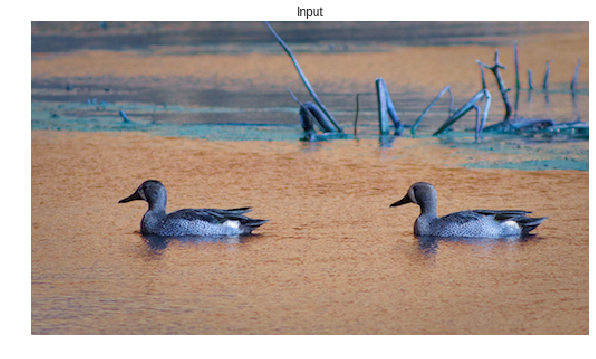

In [0]:
plt.figure(figsize=(10,8))
plt.imshow(img_input)
plt.title('Input')
plt.axis('off')

(-0.5, 499.5, 280.5, -0.5)

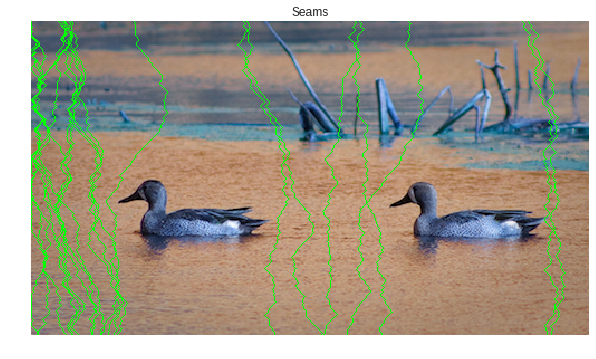

In [0]:
plt.figure(figsize=(10,8))
plt.imshow(img_overlay_seam)
plt.title('Seams')
plt.axis('off')

(-0.5, 479.5, 280.5, -0.5)

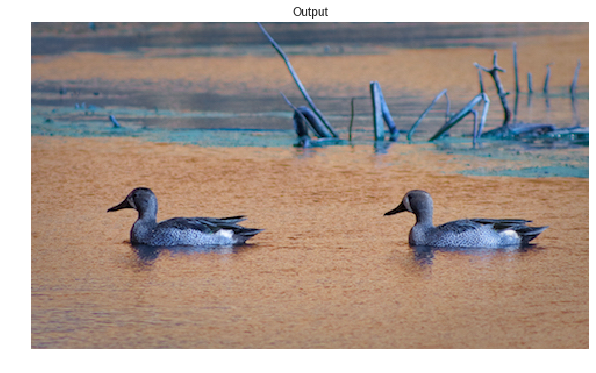

In [0]:
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.title('Output')
plt.axis('off')

In [0]:
# Draw vertical seam on top of the image 
def overlay_vertical_seam(img, seam): 
    img_seam_overlay = np.copy(img)
 
    # Extract the list of points from the seam 
    x_coords, y_coords = np.transpose([(i,int(j)) for i,j in enumerate(seam)]) 
 
    # Draw a green line on the image using the list of points 
    img_seam_overlay[x_coords, y_coords] = (0,255,0) 
    return img_seam_overlay
 
# Compute the energy matrix from the input image 
def compute_energy_matrix(img): 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
 
    # Compute X derivative of the image 
    sobel_x = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=3) 
 
    # Compute Y derivative of the image 
    sobel_y = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=3) 
 
    abs_sobel_x = cv2.convertScaleAbs(sobel_x) 
    abs_sobel_y = cv2.convertScaleAbs(sobel_y) 
 
    # Return weighted summation of the two images i.e. 0.5*X + 0.5*Y 
    return cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0) 
 
# Find vertical seam in the input image 
def find_vertical_seam(img, energy): 
    rows, cols = img.shape[:2] 
 
    # Initialize the seam vector with 0 for each element 
    seam = np.zeros(img.shape[0]) 
 
    # Initialize distance and edge matrices 
    dist_to = np.zeros(img.shape[:2]) + float('inf')
    dist_to[0,:] = np.zeros(img.shape[1]) 
    edge_to = np.zeros(img.shape[:2]) 
 
    # Dynamic programming; iterate using double loop and compute the paths efficiently 
    for row in range(rows-1): 
        for col in range(cols): 
            if col != 0 and dist_to[row+1, col-1] > dist_to[row, col] + energy[row+1, col-1]: 
                dist_to[row+1, col-1] = dist_to[row, col] + energy[row+1, col-1]
                edge_to[row+1, col-1] = 1 
 
            if dist_to[row+1, col] > dist_to[row, col] + energy[row+1, col]: 
                dist_to[row+1, col] = dist_to[row, col] + energy[row+1, col] 
                edge_to[row+1, col] = 0 

            if col != cols-1 and dist_to[row+1, col+1] > dist_to[row, col] + energy[row+1, col+1]: 
                    dist_to[row+1, col+1] = dist_to[row, col] + energy[row+1, col+1] 
                    edge_to[row+1, col+1] = -1 
 
    # Retracing the path 
    # Returns the indices of the minimum values along X axis.
    seam[rows-1] = np.argmin(dist_to[rows-1, :]) 
    for i in (x for x in reversed(range(rows)) if x > 0): 
        seam[i-1] = seam[i] + edge_to[i, int(seam[i])] 
 
    return seam 
 
# Remove the input vertical seam from the image 
def remove_vertical_seam(img, seam): 
    rows, cols = img.shape[:2] 
 
    # To delete a point, move every point after it one step towards the left 
    for row in range(rows): 
        for col in range(int(seam[row]), cols-1): 
            img[row, col] = img[row, col+1] 
 
    # Discard the last column to create the final output image 
    img = img[:, 0:cols-1] 
    return img 
 
img_input = cv2.imread('ducks.jpg') 
 
    # Use a small number to get started. Once you get an 
    # idea of the processing time, you can use a bigger number. 
    # To get started, you can set it to 20. 
num_seams = int(20) 
 
img = np.copy(img_input) 
img_overlay_seam = np.copy(img_input) 
energy = compute_energy_matrix(img) 
 
for i in range(num_seams): 
        seam = find_vertical_seam(img, energy) 
        img_overlay_seam = overlay_vertical_seam(img_overlay_seam, seam)
        img = remove_vertical_seam(img, seam) 
        energy = compute_energy_matrix(img) 
        print('Number of seams removed = ', i+1) 

Number of seams removed =  1
Number of seams removed =  2
Number of seams removed =  3
Number of seams removed =  4
Number of seams removed =  5
Number of seams removed =  6
Number of seams removed =  7
Number of seams removed =  8
Number of seams removed =  9
Number of seams removed =  10
Number of seams removed =  11
Number of seams removed =  12
Number of seams removed =  13
Number of seams removed =  14
Number of seams removed =  15
Number of seams removed =  16
Number of seams removed =  17
Number of seams removed =  18
Number of seams removed =  19
Number of seams removed =  20
